# RAG - Exploration

#### This notebook follows the official [LangChain RAG tutorial](https://python.langchain.com/docs/tutorials/rag/) and includes additional exploration, documentation, insights, and observations.  
The goal is to gain a solid understanding of how to build a basic RAG pipeline.


# Table of Contents
1. [Setting up the environment](#1.Setting-up-the-environment)
2. [Preview](#2.Preview)
3. [Detailed Break down](#3.Detailed-break-down)
   
    A. [Indexing](#A.Indexing)
   
    B. [Retrieval and Generation](#B.Retrieval-and-Generation)
   
5. [Query Analysis](#4.Query-Analysis)



## 1.Setting up the environment

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Configure logging FIRST ---
# So you can see the log messages from config.py when it's imported
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Notebook logging configured.") # Optional: Confirm logging setup

# --- Add src directory to Python's path ---
import sys
import os

# Get the absolute path of the directory containing the notebook
notebook_dir = os.getcwd()
# Go up one level to the project root
project_root = os.path.dirname(notebook_dir)
# Construct the path to the 'src' directory
src_path = os.path.join(project_root, "src")

# Check if the 'src' path is already in sys.path to avoid duplicates
if src_path not in sys.path:
    sys.path.append(src_path)
    logging.info(f"Added '{src_path}' to sys.path")
else:
    logging.info(f"'{src_path}' already in sys.path")

# --- Import config from src ---
try:
    logging.info("Attempting to import 'config' from src...\n")
    import config # it will display logging from config
    logging.info("Successfully imported 'config'.")
except ImportError as e:
    logging.error(f"Import error: {e}")
    logging.error(f"Current sys.path: {sys.path}")

2025-05-06 15:01:59,207 - INFO - Notebook logging configured.
2025-05-06 15:01:59,208 - INFO - Added 'C:\Users\minhm\OneDrive - Université Côte d'Azur\SERVIER\src' to sys.path
2025-05-06 15:01:59,210 - INFO - Attempting to import 'config' from src...

2025-05-06 15:01:59,222 - INFO - Current working directory: C:\Users\minhm\OneDrive - Université Côte d'Azur\SERVIER\exploration
2025-05-06 15:01:59,224 - INFO - LLM API Key loaded from environment.
2025-05-06 15:01:59,225 - INFO - LangSmith API Key loaded.
2025-05-06 15:01:59,227 - INFO - LangSmith project name set to: rag_pipeline_llm_evaluation
2025-05-06 15:01:59,229 - INFO - PDF file path configured: C:\Users\minhm\OneDrive - Université Côte d'Azur\SERVIER\data\2411.15594v5.pdf
2025-05-06 15:01:59,230 - INFO - Successfully imported 'config'.


In [3]:
# dotenv_path = os.path.join(os.path.dirname(os.getcwd()), 'src\.env')
# print(dotenv_path)
# load_dotenv(dotenv_path)

In [4]:
#!pip install -U langchain langchain-openai

# Set the environment variable for OpenAI API key.
# LangChain does not automatically use config.LLM_API_KEY; 
# it requires the standard environment variable OPENAI_API_KEY to be set.
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = config.LLM_API_KEY

from langchain.chat_models import init_chat_model  # Initialize chat model

# Use temperature=0 to ensure deterministic output.
# By default, temperature > 0 introduces randomness into generation.
#
# you can select a different chat model as in the tutorial, 
# but I opted for gpt-3.5-turbo to keep costs low.
llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")

In [5]:
#!pip install -qU langchain-openai 
from langchain_openai import OpenAIEmbeddings # Initialize embedding model

# You can choose a different embedding model, as shown in the tutorial, 
# but I chose a smaller one due to budget constraints.
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [6]:
#!pip install -qU langchain-core
from langchain_core.vectorstores import InMemoryVectorStore

# InMemoryVectorStore is a simple option suitable for exploring RAG concepts,
# but for production use, it is recommended to use a more robust vector store.
vector_store = InMemoryVectorStore(embeddings)

## 2.Preview

In [7]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

if not os.environ.get("USER_AGENT"):
    os.environ["USER_AGENT"] = "my-python-client/5.0" 

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

2025-05-06 15:02:00,291 - WARNING - USER_AGENT environment variable not set, consider setting it to identify your requests.
2025-05-06 15:02:05,616 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [8]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

2025-05-06 15:02:10,189 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-06 15:02:11,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Task decomposition is the process of breaking down a problem into multiple thought steps, generating multiple thoughts per step in a tree structure. It can be achieved through LLM with simple prompting, task-specific instructions, or human inputs. This approach transforms complex tasks into smaller and simpler steps for easier interpretation and execution by models or agents.


These are four answers generated and tutorial answer using `gpt-4o-mini`, `text-embedding-3-large`, and `InMemoryVectorStore`. The first three answers were generated with temperature = 0, while the fourth used the default setting (temperature > 0), which introduces some randomness in the output.

- **Answer 1**: Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps. This can be achieved through techniques like Chain of Thought (CoT) prompting, which encourages models to think step by step, or by using task-specific instructions. It allows for better planning and execution by clarifying the logical relationships between tasks.

- **Answer 2**: Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps. This can be achieved through techniques like Chain of Thought (CoT) prompting, which encourages models to think step by step, or by using task-specific instructions. It allows for better planning and execution by clarifying the logical relationships between tasks.

- **Answer 3**: Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps. This can be achieved through techniques like Chain of Thought (CoT) prompting, which encourages models to think step by step, or by using task-specific instructions. It allows for better planning and execution by clarifying the logical relationships between tasks.

- **Answer 4**: Task Decomposition is the process of breaking down complex tasks into smaller, more manageable steps. It can be achieved through various methods, including prompting models to "think step by step" or using specific instructions tailored to tasks. This approach enhances performance by enabling more structured reasoning and easier execution of the overall task.

- **Tutorial Answer**: Task Decomposition is the process of breaking down a complicated task into smaller, manageable steps to facilitate easier execution and understanding. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) guide models to think step-by-step, allowing them to explore multiple reasoning possibilities. This method enhances performance on complex tasks and provides insight into the model's thinking process.

### Observation: Output Variability with Default LLM Settings

**Setup & Finding:**
*   Executed a RAG pipeline 3 times with identical components:
    *   **Chat Model:** `gpt-4o-mini` (via `init_chat_model`)
    *   **Embedding:** `text-embedding-3-large`
    *   **Vector Store:** `InMemoryVectorStore` (same indexed data)
*   **Result:** Each run produced a different answer to the same input question.

**Analysis & Root Cause:**
*   **Deterministic Components:** Embedding generation and vector search are inherently deterministic.
*   **LLM Variability:** The source of variation is the chat model (`gpt-4o-mini`).
    *   **Default `temperature`:** When `temperature` is unspecified during initialization (`init_chat_model`), it typically defaults to a value > 0.
    *   **Effect:** `temperature > 0` introduces stochasticity (randomness) into the LLM's token selection process during text generation, resulting in varied outputs for identical inputs. ( **Observed behavior differs slightly from the tutorial results due to this randomness.**)

**Verification & Solution:**
*   **Experiment:** Re-executed the pipeline after explicitly initializing the chat model with `temperature=0`:
    ```python
    llm = init_chat_model("gpt-4o-mini", model_provider="openai", temperature=0)
    ```
*   **Outcome:** Setting `temperature=0` resulted in consistent, identical answers across subsequent runs for the same question.

**Key Takeaway:**
For reproducible LLM outputs, explicitly set `temperature=0`. Be aware that this removes the inherent creativity/diversity associated with higher temperature settings. The choice depends on the desired application behavior.

Now, due to resource constraints, I will use `gpt-3.5-turbo` as the chat model and `text-embedding-3-small` for embeddings, while keeping the same vector store.

## 3.Detailed break down
### A.Indexing
#### A.1 Loading documents

In [9]:
# Goal: Extract only the core content of the blog post, ignoring navigation, footers, etc.
# We use BeautifulSoup's SoupStrainer to specify which HTML elements to keep.
# Here, we target elements with CSS classes commonly used for blog titles, headers, and main content areas. This is "what we want to read" part
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# Initialize the WebBaseLoader with:
# 1. web_paths: A tuple containing the URL(s) to load. Here, it's a specific blog post.
# 2. bs_kwargs: A dictionary of keyword arguments to pass directly to the underlying BeautifulSoup parser.
#    - "parse_only": This argument takes the SoupStrainer defined above. It tells BeautifulSoup
#                    to parse *only* the parts of the HTML document that match the strainer criteria.
#                    This significantly cleans the input data early in the process.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), # Target URL
    bs_kwargs={"parse_only": bs4_strainer}, # Apply the content strainer
)

# The .load() method executes the following steps:
# 1. Fetches the HTML content from the specified URL.
# 2. Uses BeautifulSoup (configured with the strainer) to parse the HTML.
# 3. Extracts the text content from the strained HTML elements.
# 4. Packages the extracted text and metadata (like the source URL) into a Langchain Document object.
# Returns a list of Document objects (in this case, expected to be just one).
docs = loader.load()


# Basic sanity check: Assert that exactly one document was created from the single URL.
assert len(docs) == 1, f"Expected 1 document, but got {len(docs)}"

# Print the length (number of characters) of the extracted page content from the first document.
# This provides a quick measure of the amount of relevant text successfully extracted.
print(f"Total characters extracted from relevant sections: {len(docs[0].page_content)}")

Total characters extracted from relevant sections: 43130


In [10]:
# Preview the first ~ 980 characters of the first document to inspect the loaded content
print(docs[0].page_content[:971])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.





#### A.2 Splitting documents

In [11]:
# Import text splitting class from Langchain
from langchain_text_splitters import RecursiveCharacterTextSplitter

# --- Text Splitter ---
# The goal here is to break down the loaded document(s) (from the previous step)
# into smaller, manageable chunks.

# Initialize the RecursiveCharacterTextSplitter with specific parameters:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,       # Defines the target size for each chunk in characters.
                           # This value is chosen based on a balance between being small enough
                           # for embedding models and large enough to retain meaningful context.
                           # It's often tuned based on the embedding model and data characteristics.

    chunk_overlap=200,     # Specifies the number of characters that will overlap between
                           # consecutive chunks. Overlap helps to preserve context across chunk
                           # boundaries, ensuring that sentences or ideas aren't abruptly cut off,
                           # which could hinder the understanding of the text.

    add_start_index=True,  # If True, this adds metadata to each chunk indicating its
                           # starting character index in the original document.
)


# The `split_documents` method takes the list of Document objects (e.g., 'docs' from the
# previous loading step) and applies the configured splitting logic.
# `RecursiveCharacterTextSplitter` attempts to split text by a predefined list of
# separators (e.g., "\n\n", "\n", " ", "") in that order, trying to keep semantically
# related pieces of text together.
all_splits = text_splitter.split_documents(docs)

# Print the number of sub-documents (chunks) created after splitting.
# This gives an indication of how the original document(s) have been divided.
print(f"Split the loaded document(s) into {len(all_splits)} chunks/sub-documents.")

Split the loaded document(s) into 66 chunks/sub-documents.


#### A.3 Storing documents

In [12]:
# The `add_documents` method of the vector store object handles this process.
# - 'documents=all_splits': This passes the list of chunked Document objects.
# - The method iterates through these documents, generates their embeddings (if not already
#   embedded and the vector store is configured to do so), and stores them.
# - It typically returns a list of IDs assigned by the vector store to each added document.
#   These IDs can be useful for managing the documents later (e.g., updating or deleting).
document_ids = vector_store.add_documents(documents=all_splits)


# InMemoryVectorStore (in this notebook) generates new document IDs each time the program runs.
# These IDs are not persistent across sessions, as the store only keeps data in memory.


print(document_ids[:3])

2025-05-06 15:02:15,241 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['a73e3ef8-e129-4957-afc8-68f55d7ad48e', '2f6f60a3-1bdf-43af-b6cf-b5caf141c6bd', 'a8b473f2-9449-468d-b691-f5649bef5c78']


### B.Retrieval and Generation

In [13]:
# Import the 'hub' utility from Langchain.
# Langchain Hub is a central repository for discovering, sharing, and using Langchain components,
# particularly prompt templates, chains, and agents.
from langchain import hub

# --- Retrieve a Pre-defined Prompt Template ---
# The `hub.pull()` function fetches a specific component from Langchain Hub.
# - "rlm/rag-prompt": This is the identifier for the prompt being pulled.
#   - "rlm" likely refers to the user or organization that published this prompt (e.g., "Retrieval Language Model" or a user named "rlm").
#   - "rag-prompt" indicates that this is a prompt template specifically designed for
#     Retrieval-Augmented Generation (RAG) tasks.
#
# Used pre-defined prompts from the hub
prompt = hub.pull("rlm/rag-prompt")

# --- Inspect the Prompt Structure by Invoking it with Example Data ---
# To understand how the prompt template is structured and what kind of output it produces
# (before formatting for an LLM), we can invoke it with placeholder data.
#
# The `.invoke()` method of a Langchain prompt template typically takes a dictionary
# where keys correspond to the input variables expected by the template.
# For a RAG prompt, common input variables are:
#   - "context": Placeholder for the retrieved documents/chunks.
#   - "question": Placeholder for the user's query.
#
# The `.to_messages()` method converts the formatted prompt output (which might be a string
# or a more complex structure) into a list of Langchain Message objects (e.g., HumanMessage,
# AIMessage, SystemMessage).
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

# --- Verification and Output ---
# Assert that the invocation results in a single message object.
assert len(example_messages) == 1, \
       f"Expected prompt invocation to result in 1 message, but got {len(example_messages)}"

# Print the content of the first (and expected only) message.
# This allows us to see the actual text that would be sent to the LLM after the
# placeholders for "context" and "question" are filled. 
print("--- Example Prompt Content (after formatting with placeholders) ---")
print(example_messages[0].content)

--- Example Prompt Content (after formatting with placeholders) ---
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In addition to pre-defined prompt, we can use other templates.

In [26]:
from langchain_core.prompts import PromptTemplate

# Define a custom prompt template for question answering based on provided context
custom_prompt = PromptTemplate.from_template(
    template="""
You are an expert assistant. Answer the following question based only on the provided context.
Do not use any outside knowledge. Be concise and accurate.

Context:
{context}

Question:
{question}

Response:"""
)


# Format the prompt using the provided inputs
formatted_prompt = custom_prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

# Print the model's response
print(formatted_prompt[0].content)

#another templates

print("\n")
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)
formatted_prompt = custom_rag_prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

# Print the model's response
print(formatted_prompt[0].content)


You are an expert assistant. Answer the following question based only on the provided context.
Do not use any outside knowledge. Be concise and accurate.

Context:
(context goes here)

Question:
(question goes here)

Response:


Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

(context goes here)

Question: (question goes here)

Helpful Answer:


In [14]:
from langchain_core.documents import Document  # The standard Langchain class for representing pieces of text and their metadata.
from typing_extensions import List, TypedDict   # `List` is for type hinting lists.
                                              # `TypedDict` allows for defining dictionary-like structures with type hints for keys and values.

# --- Define a Typed Dictionary for Representing RAG State ---
# The `State` class is defined using `TypedDict`. This means instances of `State`
# will be dictionaries, but with this definition, type checkers (like MyPy) and
# IDEs can understand the expected keys and the types of their corresponding values.
# This improves code readability, maintainability, and helps catch errors early.
#
# In the context of a RAG pipeline, especially one orchestrated by a graph-based
# framework (e.g., Langchain's LangGraph), this `State` object would typically
# carry information as it flows through different processing nodes (steps) of the graph.
class State(TypedDict):
    """
    A TypedDict representing the state of the RAG (Retrieval-Augmented Generation)
    pipeline at various stages. This structure helps manage and pass data
    between different components of the RAG process in a clear and type-safe manner.
    """
    question: str
    # The original question posed by the user. This is typically the starting point
    # of the RAG pipeline and remains constant throughout the process.

    context: List[Document]
    # A list of Langchain `Document` objects. These are the chunks of text retrieved
    # from the vector store that are deemed relevant to the `question`.
    # This field is populated by the retrieval step. It might be initially empty or None
    # and then updated as the pipeline progresses.

    #     #eg : context :[
    #     Document(
    #         page_content="Task decomposition is the process of breaking a complex task into smaller, manageable subtasks...",
    #         metadata={"source": "https://lilianweng.github.io/posts/2023-06-23-agent/", "start_index": 0}
    #     ),
    #     Document(
    #         page_content="One common method for task decomposition is Chain-of-Thought prompting, which guides the model to reason step by step...",
    #         metadata={"source": "https://lilianweng.github.io/posts/2023-06-23-agent/", "start_index": 1}
    #     ),
    #     ...
    # ]


    

    answer: str
    # The final answer generated by the Language Model (LLM) based on the
    # `question` and the retrieved `context`. This field is populated by the
    # generation step of the RAG pipeline. It might be initially empty or None.

In [16]:
def retrieve(state: State):
    """
    Performs the retrieval step of the RAG pipeline.

    This function takes the current state (which includes the user's question)
    and uses the vector store to find relevant documents.

    Args:
        state (State): The current state of the RAG pipeline, expected to contain
                       at least the 'question' key with the user's query.

    Returns:
        dict: A dictionary with a 'context' key. The value is a list of
              Langchain `Document` objects retrieved from the vector store
              that are semantically similar to the input question.
              This dictionary is intended to update the 'context' field in the
              main RAG state.
    """
    print("--- Executing Retrieval Step ---")
    question = state["question"]
    print(f"Retrieving documents for question: '{question}'")

    # Perform a similarity search in the vector store using the question from the state.
    # The `similarity_search` method returns a list of document chunks that are most relevant to the query.
    #
    # Although we previously stored the chunks in  'document_ids', 
    # we do not need to use those IDs here — the vector store automatically compares the embeddings of the query
    # against all stored document vectors to find the most similar ones.
    retrieved_docs = vector_store.similarity_search(question) 
    
    print(f"Retrieved {len(retrieved_docs)} documents.")
    if retrieved_docs:
        print(f"Content of the first retrieved doc (first 100 chars): '{retrieved_docs[0].page_content[:100]}...'")

    # Return a dictionary structured to update the 'context' field of the State.
    return {"context": retrieved_docs}


def generate(state: State):
    """
    Performs the generation step of the RAG pipeline.

    This function takes the current state (which includes the user's question
    and the retrieved context) and uses a Language Model (LLM) to generate
    an answer.

    Args:
        state (State): The current state of the RAG pipeline, expected to contain
                       the 'question' and the 'context' (list of retrieved documents).

    Returns:
        dict: A dictionary with an 'answer' key. The value is the string content
              of the LLM's generated response. This dictionary is intended to
              update the 'answer' field in the main RAG state.
    """
    print("--- Executing Generation Step ---")
    question = state["question"]
    context_documents = state["context"]

    if not context_documents:
        print("Warning: No context provided for generation. LLM will answer based on its general knowledge.")
        # Optionally, handle this case differently, e.g., return a specific message
        # or skip LLM call if context is strictly required.

    # Combine the page content of all retrieved documents into a single string.
    # This combined text will serve as the context for the LLM.
    # Documents are typically joined by a double newline for readability by the LLM.
    docs_content = "\n\n".join(doc.page_content for doc in context_documents)
    
    # Format the prompt with the user's question and the consolidated context.
    # The 'prompt.invoke()' method typically prepares the input in the format
    # expected by the LLM (e.g., a list of Message objects for chat models).
    messages = prompt.invoke({"question": question, "context": docs_content})
    # If `prompt` directly returns messages, this line is fine.
    # If `prompt.invoke` returns a string and `llm` expects messages, conversion might be needed:
    # e.g., from langchain_core.messages import HumanMessage
    # messages = [HumanMessage(content=prompt.invoke(...))]


    print(f"Sending to LLM. Question: '{question}'")
    # Invoke the Language Model with the formatted messages (prompt + context + question).
    response = llm.invoke(messages)
    # The 'response' object from an LLM call often has a 'content' attribute
    # holding the actual generated text.

    # Return a dictionary structured to update the 'answer' field of the State.
    return {"answer": response.content}

We'll use LangGraph to tie together the retrieval and generation steps into a single application. 
The benefits of LangGraph include:

- Support for multiple invocation modes: this logic would need to be rewritten if we wanted to stream output tokens, or stream the results of individual steps;
- Automatic support for tracing via LangSmith and deployments via LangGraph Platform;
- Support for persistence, human-in-the-loop, and other features.

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

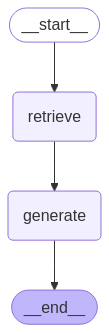

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

But LangGraph is not required to build a RAG application. So we can implement the same application logic through invocations of the individual components:

In [19]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

--- Executing Retrieval Step ---
Retrieving documents for question: 'What is Task Decomposition?'


2025-05-06 15:02:23,285 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved 4 documents.
Content of the first retrieved doc (first 100 chars): 'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each...'
--- Executing Generation Step ---
Sending to LLM. Question: 'What is Task Decomposition?'


2025-05-06 15:02:24,563 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Context: [Document(id='079be118-ae11-42c7-ad91-b9a6c0586bb9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='75250e00-d9e3-46bb-9a14-68ad6989d4c9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023

In [22]:
# question = "What is Task Decomposition?"

# retrieved_docs = vector_store.similarity_search(question)
# docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
# prompt = prompt.invoke({"question": question, "context": docs_content})
# answer = llm.invoke(prompt)
#print(answer.content)

In [23]:
# Stream the steps of the StateGraph in real-time while processing the input question.
# This allows us to track the progress of the application as it moves through the retrieve and generate steps.

# Loop through the steps of the graph, streaming the updates
for step in graph.stream(
    {"question": "What is Task Decomposition?"},  # Input: The user's question that will be processed
    stream_mode="updates"  
):

    print(f"{step}\n\n----------------\n")

--- Executing Retrieval Step ---
Retrieving documents for question: 'What is Task Decomposition?'


2025-05-06 15:02:43,869 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved 4 documents.
Content of the first retrieved doc (first 100 chars): 'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each...'
{'retrieve': {'context': [Document(id='079be118-ae11-42c7-ad91-b9a6c0586bb9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3)

2025-05-06 15:02:45,149 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'generate': {'answer': 'Task Decomposition is a technique that breaks down complex tasks into smaller and simpler steps to make them more manageable. It can be done using prompting techniques, task-specific instructions, or human inputs to guide the decomposition process. Different search processes like BFS or DFS can be used to explore multiple reasoning possibilities at each step during task decomposition.'}}

----------------



In [24]:
# Stream tokens:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

--- Executing Retrieval Step ---
Retrieving documents for question: 'What is Task Decomposition?'


2025-05-06 15:02:45,574 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved 4 documents.
Content of the first retrieved doc (first 100 chars): 'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each...'
--- Executing Generation Step ---
Sending to LLM. Question: 'What is Task Decomposition?'


2025-05-06 15:02:46,165 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


|Task| decomposition| is| the| process| of| breaking| down| a| problem| into| multiple| thought| steps|,| generating| multiple| thoughts| per| step|,| creating| a| tree| structure| for| exploring| reasoning| possibilities|.| It| can| be| achieved| through| L|LM| prompting|,| task|-specific| instructions|,| or| human| inputs|.| Task| decomposition| helps| transform| big| tasks| into| smaller|,| more| manageable| tasks| for| better| understanding| and| planning|.||

## 3.Query Analysis

Query analysis is the process of understanding and interpreting a user's query to determine its intent and context. It involves detecting the user's goals, recognizing key entities, and considering context to provide more accurate and relevant responses. This step is crucial in improving the efficiency of search engines, chatbots, and other information retrieval systems.

In [28]:
# total number of document chunks
total_documents = len(all_splits)

# --- Determine approximate boundary for thirds ---
# Integer division to find the index marking the end of the first third.
third = total_documents // 3

# --- Assign a 'section' metadata field based on chunk position ---
for i, document in enumerate(all_splits):
    # Assign 'beginning', 'middle', or 'end' to the 'section' metadata
    # based on whether the chunk falls into the first, second, or final third
    # of the document chunk list.
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third: # Check if in the second third
        document.metadata["section"] = "middle"
    else: # Remaining chunks are in the final third
        document.metadata["section"] = "end"

# --- Display metadata of the first chunk (for verification) ---
print(f"Metadata of the first chunk after adding 'section': {all_splits[0].metadata}")

Metadata of the first chunk after adding 'section': {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8, 'section': 'beginning'}


Update the documents in our vector store

In [29]:
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

2025-05-06 15:16:10,909 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [30]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [31]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State): 
    """
    Analyzes the user's natural language question and converts it into a
    structured representation using an LLM.

    This step is often used in more advanced RAG pipelines to:
    - Extract key entities or keywords for more targeted retrieval.
    - Identify user intent or specific constraints from the query.
    - Rephrase the query for better retrieval performance.

    Args:
        state (State): The current RAG state, expected to contain the
                       user's original 'question'.

    Returns:
        dict: A dictionary containing the 'query' key, where the value is
              the structured output (an instance of the 'Search' Pydantic model)
              derived from the original question. This dictionary is intended to
              potentially update a 'query' field or a similar field in the main RAG state.
    """
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

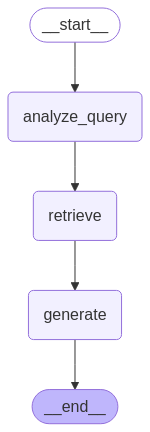

In [32]:
display(Image(graph.get_graph().draw_mermaid_png())) #updated imaged after adding Query Analysis

FINAL CODE :

In [33]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

2025-05-06 15:27:53,551 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
